**Features & Descriptions:**
- PassengerID
- Survived - (0 = No, 1 = Yes)
- Pclass - Passenger Class (1 = 1st, 2 = 2nd, 3 = 3rd)
- Name
- Sex
- Age
- SibSp - Number of Siblings/Spouses Aboard
- Parch - Number of Parents/Children Aboard
- Ticket - Ticket Number
- Fare - Passenger Fare in British pound
- Cabin - Cabin Number
- Embarked - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In this notebook, I intended to experiment with the performance of a neural network on a small-sample, structured data binary classification problem, and iterate with minimal feature engineering to see what kind of accuracy I could get. In the end, a simple logistic regression classifier performed better than both the (un-tuned) SVM as well as 3 variations of a simple neural network classifier - undoubtedly due to my inexperience implementing deep learning models.

My metrics for comparing models were based on stratified k-fold cross validation accuracy scores. The bias was calculated as a mean accuracy across folds, and the standard deviation of the accuracy across folds was taken as a measure of the model variance.

Please enjoy, and leave a comment if you feel inspired!

# 1. Module Imports

In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime

import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2, l1, l1_l2

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold

# pandas options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# plotting 
import seaborn as sns
from matplotlib import rcParams
import matplotlib.ticker as ticker
sns.set(rc={"font.size":15,
            "axes.titlesize":20,
            "axes.labelsize":18,
            "axes.titlepad":22, 
            "axes.labelpad":18, 
            "xtick.labelsize":15,
            "legend.fontsize":14, 
            "legend.title_fontsize":14})
sns.set_style('darkgrid')

# constants
FIG_SIZE = (15,5)

# 2. Data Import

In [2]:
test = pd.read_csv('./test.csv')
train = pd.read_csv('./train.csv')

print(train.shape)
print(test.shape)

comb = pd.concat([train, test], 0)
comb.info()

(891, 12)
(418, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


## get feature names

In [3]:
numeric_features = comb.select_dtypes(include=['int64','float64']).columns.tolist()
nominal_features = comb.select_dtypes(include=['object']).columns.tolist()

numeric_features.remove('Survived') # target - not a feature
numeric_features.remove('PassengerId')
# nominal_features.remove('Name')
# nominal_features.remove('Ticket') # possibly unhelpful?
# nominal_features.remove('Cabin') # mostly null

print(numeric_features)
print(nominal_features)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


# 3. Exploratory Data Analysis

In [4]:
print(numeric_features)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


## Look at missing values

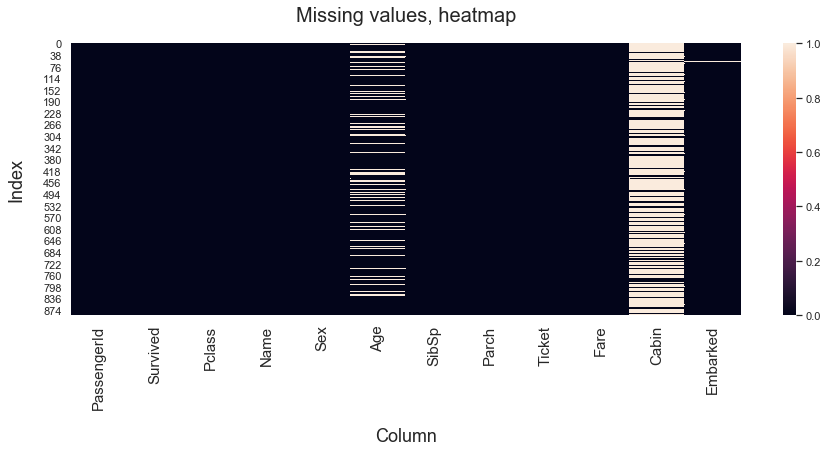

In [31]:
plt.figure(figsize=FIG_SIZE);
sns.heatmap(train.isna().astype(int));
plt.title('Missing values, heatmap');
plt.ylabel('Index');
plt.xlabel('Column');

In [6]:
train.isna().mean() * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

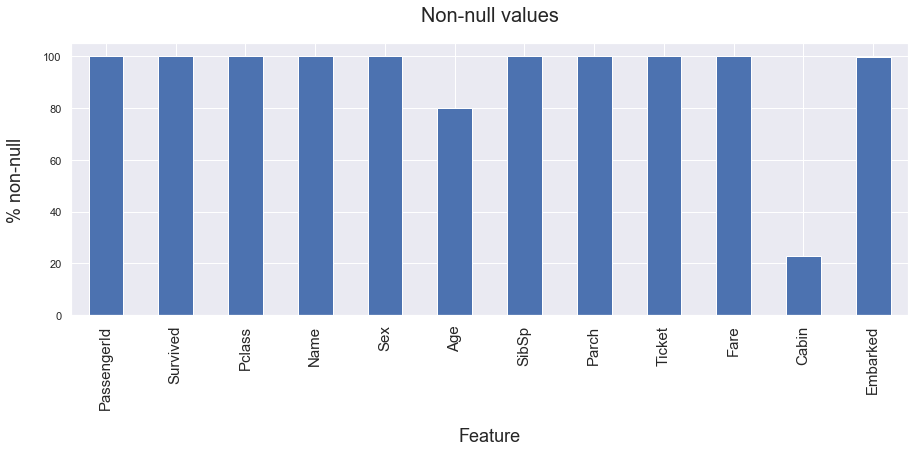

In [27]:
plt.figure(figsize=FIG_SIZE)
(100 - train.isna().mean() * 100).plot.bar();
plt.title('Non-null values');
plt.ylabel('% non-null');
plt.xlabel('Feature');

`Age`, `Cabin`, and `Embarked` all have missing values, with `Cabin` having the lowest data recovery of any input feature. 

## Check the distribution of 'Survived' classes in training data

0    61.616162
1    38.383838
Name: Survived, dtype: float64


Text(0.5, 1.0, 'Count of `Survived`')

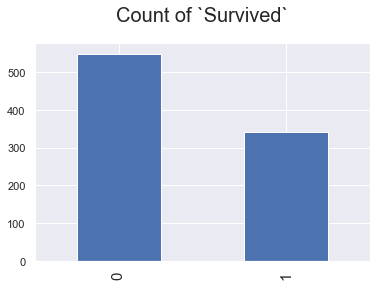

In [34]:
print(train['Survived'].value_counts() / len(train) * 100)
train['Survived'].value_counts().plot.bar();
plt.title('Count of `Survived`')

The training data has class imbalance, but the imbalance is not severe.

## SibSp

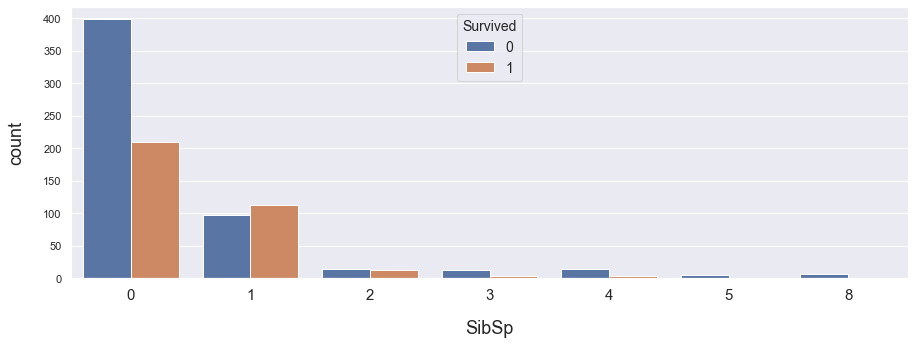

In [42]:
plt.figure(figsize=FIG_SIZE);
sns.countplot(data=train, x='SibSp', hue='Survived');

So since the distribution of `Survived` is not equal across the various values of `SibSp`, this should prove to be a useful feature for modeling with. 

## Sex

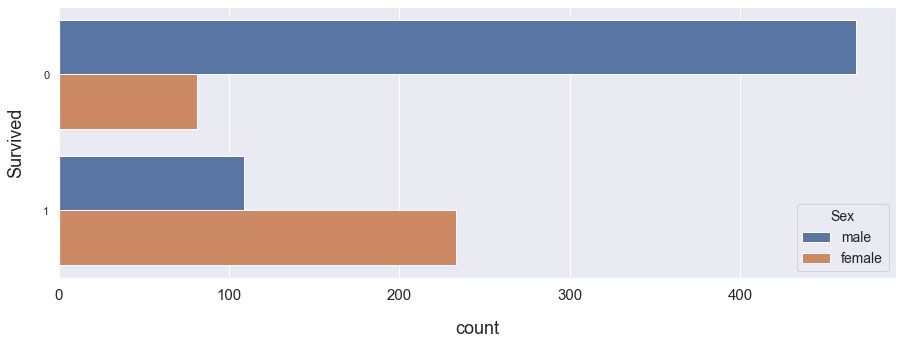

In [43]:
plt.figure(figsize=FIG_SIZE);
sns.countplot(data=train, y='Survived', hue='Sex');

Survival rate for males is much lower than females.

## Pclass

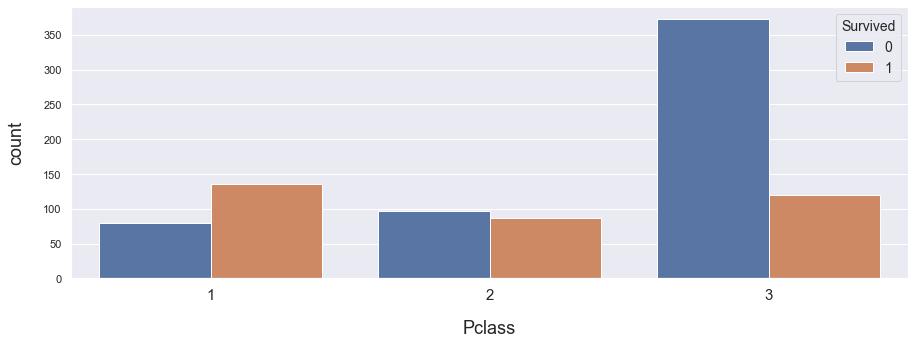

In [44]:
plt.figure(figsize=FIG_SIZE);
sns.countplot(data=train, x='Pclass', hue='Survived');

## Cabin

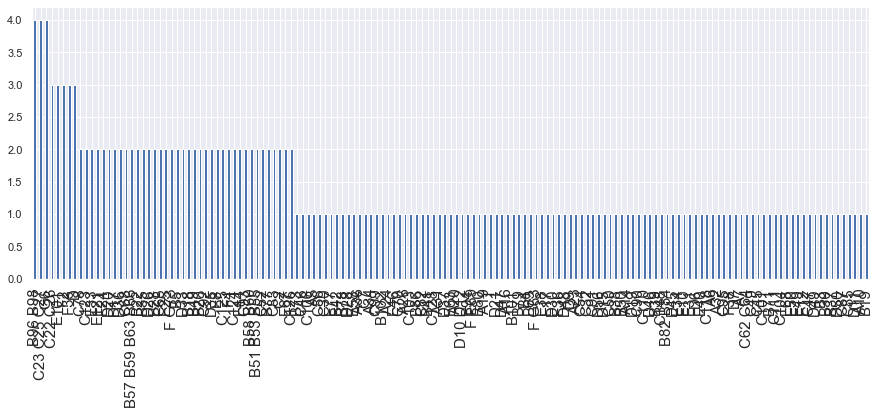

In [46]:
plt.figure(figsize=FIG_SIZE);
train['Cabin'].value_counts().sort_values(ascending=False).plot.bar(figsize=FIG_SIZE);

Individuals that share the same `Cabin` would intuitively belong to the same family. Perhaps the cabin numbering also reflects something like proximity to lifeboats, or socio-economic status of the inhabitants, which might also effect the probability of `Survival`. However, I will not be exploring this feature in depth as that was not the purpose of this notebook.

## Fare

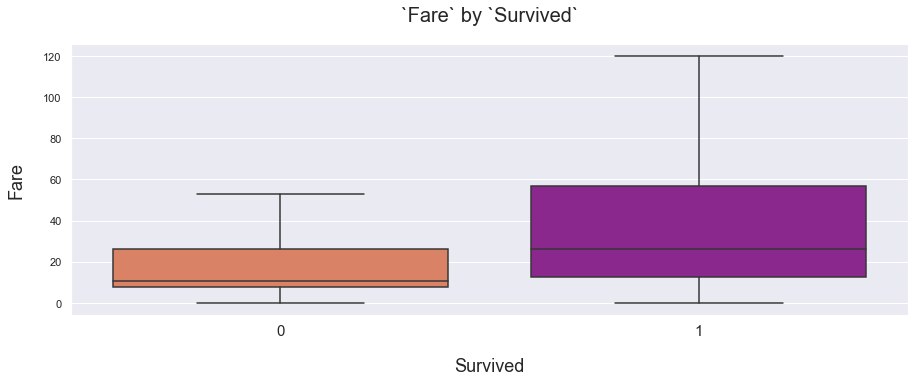

In [85]:
plt.figure(figsize=FIG_SIZE);
sns.boxplot(x="Survived", y='Fare', data=train, palette="plasma_r", showfliers=False);
plt.title("`Fare` by `Survived`");

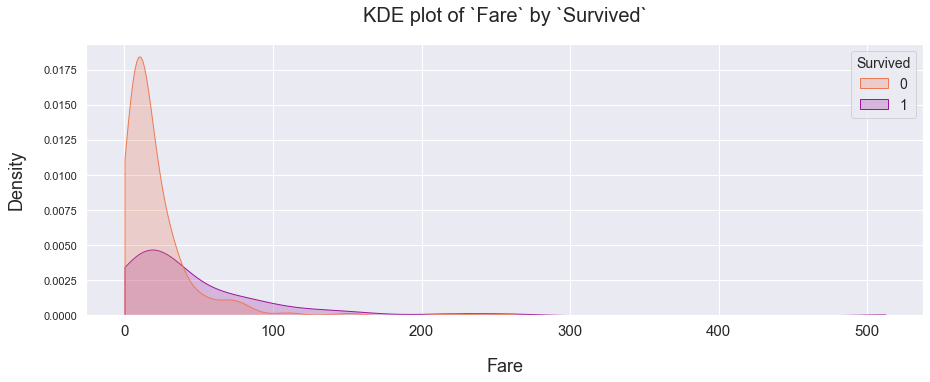

In [117]:
plt.figure(figsize=FIG_SIZE);
BINS = 25
kde = sns.kdeplot(x="Fare", data=train, hue="Survived", cut=0, fill=True, legend=True, palette="plasma_r", )
kde.title.set_text("KDE plot of `Fare` by `Survived`");

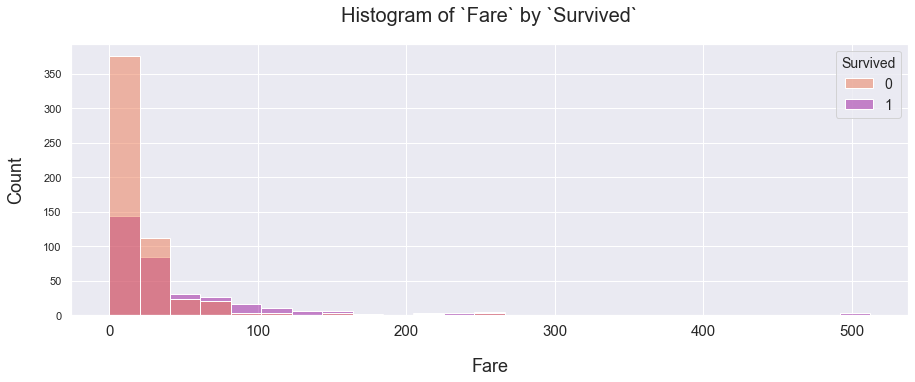

In [84]:
plt.figure(figsize=FIG_SIZE);
BINS = 25
hist = sns.histplot(x="Fare", data=train, hue="Survived", bins=BINS, fill=True, legend=True, palette="plasma_r", )
hist.title.set_text("Histogram of `Fare` by `Survived`");

Based on the KDE plot, the `Fare` contributes to probability of `Survived==1`.


Another way to look at the `Fare` variable would be to split it up into bins, and see if the probability of `Survival==1` changes from bin to bin. Binning in this way likely wouldn't help non-linear models such as Random Forest, SVM, or the Neural Network, as those models would learn the decision boundaries on their own (see https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization.html), however it might help the logistic regression classifier. 

Something to explore in the future. 

In [87]:
from sklearn.preprocessing import KBinsDiscretizer
N_BINS = 10
# enc = KBinsDiscretizer(n_bins=N_BINS, encode='onehot')
enc = KBinsDiscretizer(n_bins=N_BINS, encode='ordinal')
training_fare_vals = train[['Fare']].values
training_fare_vals_binned = enc.fit_transform(training_fare_vals) 
# training_fare_vals_binned.toarray() # for one-hot encoding
print(training_fare_vals_binned[:5])

[[0.]
 [8.]
 [2.]
 [8.]
 [3.]]


## Age

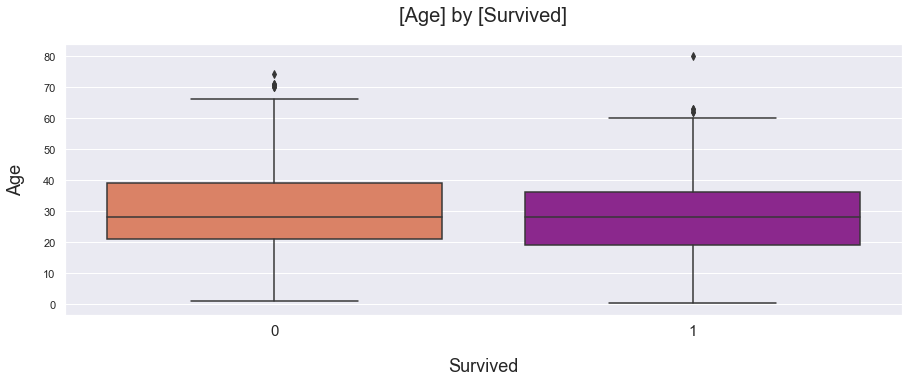

In [89]:
plt.figure(figsize=FIG_SIZE);
sns.boxplot(data=train, x='Survived', y='Age', palette="plasma_r");
plt.title("[Age] by [Survived]");

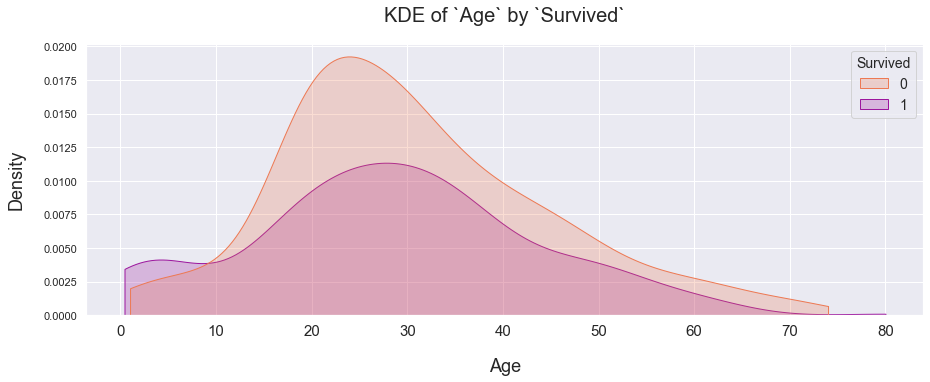

In [119]:
plt.figure(figsize=FIG_SIZE);
BINS = 25
kde = sns.kdeplot(x="Age", data=train, hue="Survived", cut=0, fill=True, legend=True, palette="plasma_r")
kde.title.set_text("KDE of `Age` by `Survived`");

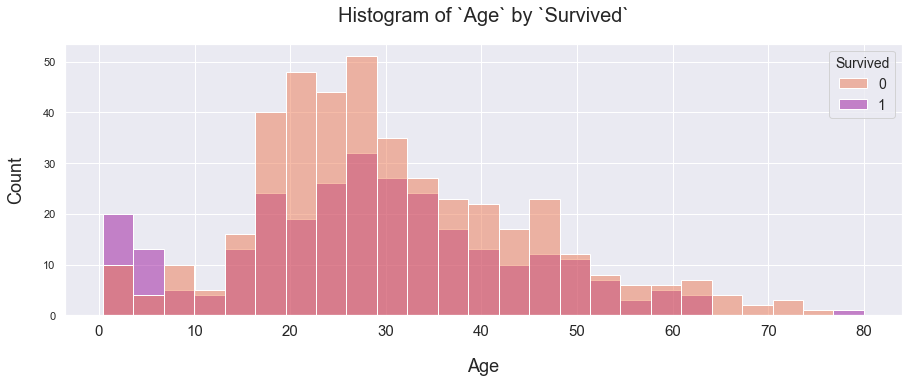

In [90]:
plt.figure(figsize=FIG_SIZE);
BINS = 25
hist = sns.histplot(x="Age", data=train, hue="Survived", bins=BINS, fill=True, legend=True, palette="plasma_r")
hist.title.set_text("Histogram of `Age` by `Survived`");

# 4. Feature Engineering

## Name -> Title

The processing for the `Title` feature was taken from the analysis done by Sreevishnu Damodaran here: https://www.kaggle.com/sreevishnudamodaran/ultimate-eda-fe-neural-network-model-top-2

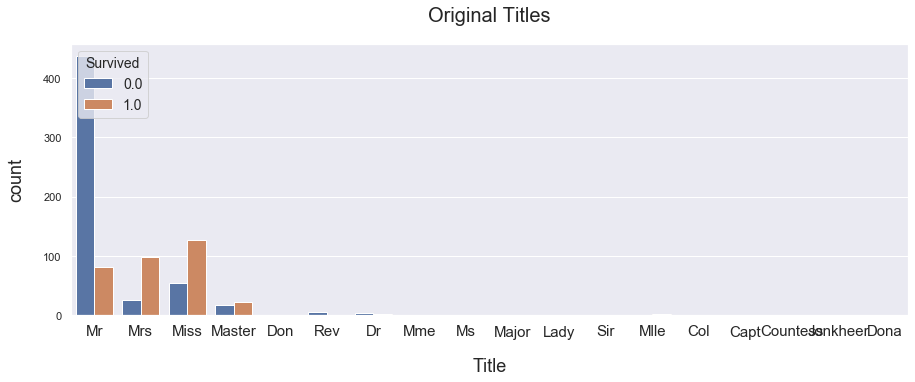

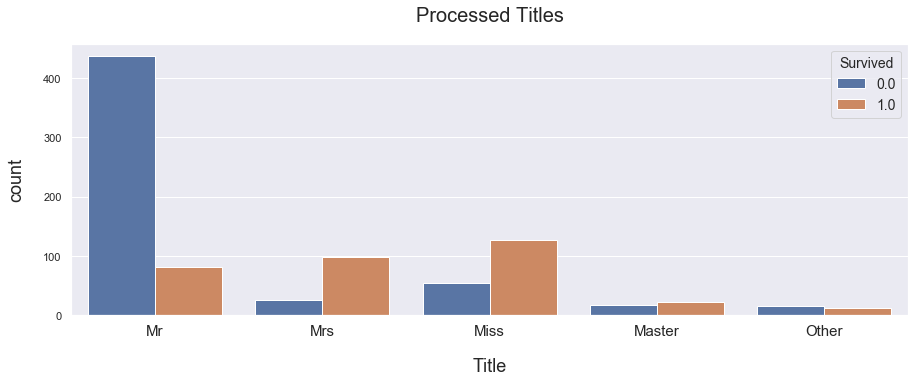

In [91]:
comb['Title'] = comb['Name']
comb['Title'] = comb['Name'].str.extract('([A-Za-z]+)\.', expand=True)

plt.figure(figsize=FIG_SIZE)
sns.countplot(data=comb, x='Title', hue='Survived').set(title = 'Original Titles');

# replace least common titles with 'Other'
title_counts = comb['Title'].value_counts()
top_names = title_counts[title_counts > 10].index
comb['Title'] = comb['Title'].apply(lambda x: x if x in top_names else 'Other')

# plot
plt.figure(figsize=FIG_SIZE)
sns.countplot(data=comb, x='Title', hue='Survived').set(title = 'Processed Titles');

if 'Title' not in nominal_features:
    nominal_features.append('Title')
    nominal_features.remove('Name')

Clearly there is some variance being captured by the `Title` feature. 

## Filling Missing Cabin Names

In [92]:
comb['Cabin'] = comb['Cabin'].fillna(value='N')

## One-Hot Encode Categorical Values

In [93]:
nominal_features.remove('Ticket') # currently unused
nominal_features.remove('Cabin') # currently unused

In [94]:
comb[nominal_features].head()

,Sex,Embarked,Title
0,male,S,Mr
1,female,C,Mrs
2,female,S,Miss
3,female,S,Mrs
4,male,S,Mr


In [95]:
# copy processed features
df_full = comb[numeric_features + nominal_features].copy()

# one-hot encode nominal features and drop original unencoded features
df_full = pd.concat([df_full, pd.get_dummies(data = df_full[nominal_features])], axis=1)
df_full = df_full.drop(nominal_features, 1)

# print
print(df_full.shape)
df_full.head()

(1309, 15)


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,3,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,0,0
1,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,1,0
2,3,26.0,0,0,7.9250,1,0,0,0,1,0,1,0,0,0
3,1,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,1,0
4,3,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,0,0


## Imputation of Missing Values

In [96]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 5)
df_full.loc[:, :] = imputer.fit_transform(df_full.values)

In [97]:
# check for nulls
df_full.isna().mean() * 100

Pclass          0.0
Age             0.0
SibSp           0.0
Parch           0.0
Fare            0.0
Sex_female      0.0
Sex_male        0.0
Embarked_C      0.0
Embarked_Q      0.0
Embarked_S      0.0
Title_Master    0.0
Title_Miss      0.0
Title_Mr        0.0
Title_Mrs       0.0
Title_Other     0.0
dtype: float64

## Create training and test sets

In [98]:
# create training and test set
features = df_full.columns
target = 'Survived'

In [99]:
df_full[target] = comb[target] # add target
df_full['PassengerId'] = comb['PassengerId'] # add ID

In [100]:
df_train = df_full[:train.shape[0]]
df_test = df_full[train.shape[0]:]

# 5. Modeling

In [124]:
def plot_results_accuracy(results):
    plt.plot(results, marker='o');
    plt.xlabel('split');
    plt.ylabel('accuracy');
    plt.title('Stratified K Fold Accuracy');
    print("Score w/ 95 pct CI: %0.2f (+/- %0.2f)" % (results.mean(), results.std() * 2))

## Setup training & validation sets

In [ ]:
X = df_train[features].values
y = df_train[target].values

TRAIN_SIZE = 0.7
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=TRAIN_SIZE, shuffle=True)

## dummy classifier

In [105]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(X_train, y_train)
acc = clf.score(X_val, y_val)
print('dummy classifier accuracy:', round(acc, 2))

dummy classifier accuracy: 0.62


## logistic regression

In [106]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
acc = lr.score(X_val, y_val)
print('logistic regression classifier accuracy:', round(acc, 2))

logistic regression classifier accuracy: 0.81


Score w/ 95 pct CI: 0.83 (+/- 0.07)


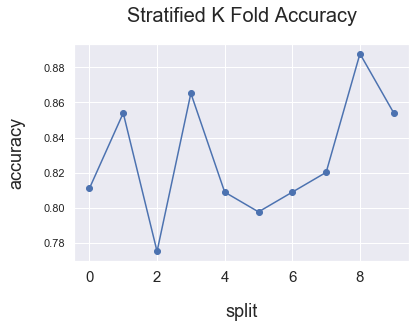

In [107]:
# create a stratified k fold object
stratkfold = StratifiedKFold(n_splits = 10, shuffle = False)

# perform cross validation across the N_SPLITS stratified folds
results = cross_val_score(lr, X, y, cv = stratkfold, scoring = 'accuracy')

plot_results_accuracy(results)

## random forest

Train a random forest to start, as a baseline classifier, to have something to compare the neural network performance with. 

Score w/ 95 pct CI: 0.81 (+/- 0.08)


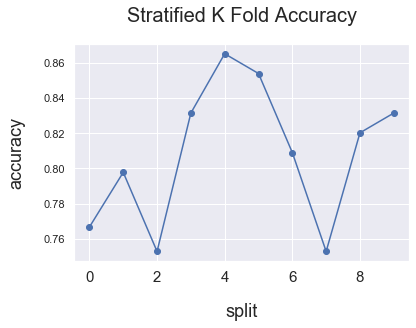

In [109]:
# create RF model
rfc = RandomForestClassifier(n_estimators=100)

# create a stratified k fold object
stratkfold = StratifiedKFold(n_splits = 10, shuffle = False)

# perform cross validation across the N_SPLITS stratified folds
results = cross_val_score(rfc, X, y, cv = stratkfold, scoring = 'accuracy')

plot_results_accuracy(results)

# SVM

Score w/ 95 pct CI: 0.68 (+/- 0.09)


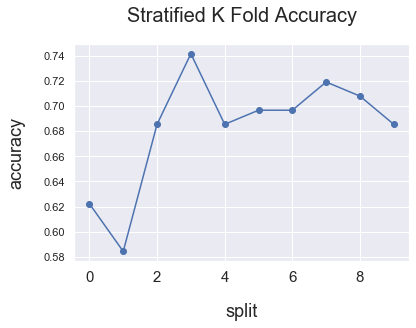

In [110]:
# create model
svc = SVC()

# create a stratified k fold object
stratkfold = StratifiedKFold(n_splits = 10, shuffle = False)

# perform cross validation across the N_SPLITS stratified folds
results = cross_val_score(svc, X, y, cv = stratkfold)

plot_results_accuracy(results)

SVC performance is much worse than the random forest classifier.

## Create submission file for logistic regression

In [153]:
# logistic regression
X_test = df_test[features].values
y_pred = lr.predict(X_test).astype(int).flatten()

submission = pd.DataFrame(
    { 
        'PassengerId': df_test['PassengerId'], 
        'Survived': y_pred
    }
)
submission.to_csv("lr_submission.csv", index=False)

# neural network

Train a simple, unoptimized neural network to check it's performance.

In [121]:
## parameters
BATCH_SIZE = 16
EPOCHS = 100
N_SPLITS = 5

In [115]:
# helper functions

def run_cv_on_estimator(build_fn, x_train, y_train, 
                        epochs = EPOCHS, 
                        batch_size = BATCH_SIZE, 
                        n_splits = N_SPLITS, 
                        shuffle = False, 
                        scoring = 'accuracy'):

    # we're going to use sklearn's cross validation functions, so we'll wrap our keras model in an sklearn model wrapper
    estimator = KerasClassifier(build_fn = create_model_0, epochs = epochs, batch_size = batch_size, verbose = 1)

    # create a stratified k fold object
    stratkfold = StratifiedKFold(n_splits = n_splits, shuffle = shuffle)

    # perform cross validation across the N_SPLITS stratified folds
    results = cross_val_score(estimator, x_train, y_train, cv = stratkfold, scoring = scoring)
    
    return results

## model 0

Model: "titanic_m0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 6)                 96        
_________________________________________________________________
layer_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
output (Dense)               (None, 1)                 7         
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6944 - accuracy: 0.5562
Epoch 2/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6319 - accuracy: 0.6924
Epoch 3/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6110 - accuracy: 0.6924
Epoch 4/100
45/45 [==============================] - 0s 2ms/step - loss: 0.5973 - accuracy:

45/45 [==============================] - 0s 1ms/step - loss: 0.4537 - accuracy: 0.7896
Epoch 43/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4494 - accuracy: 0.7924
Epoch 44/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4482 - accuracy: 0.7910
Epoch 45/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4471 - accuracy: 0.7910
Epoch 46/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4488 - accuracy: 0.7924
Epoch 47/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4415 - accuracy: 0.7980
Epoch 48/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4448 - accuracy: 0.7938
Epoch 49/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4397 - accuracy: 0.8008
Epoch 50/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4360 - accuracy: 0.7952
Epoch 51/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4371 - accuracy: 0.7910
Epoch 52/100


45/45 [==============================] - 0s 2ms/step - loss: 0.5834 - accuracy: 0.7237
Epoch 17/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5783 - accuracy: 0.7237
Epoch 18/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5701 - accuracy: 0.7321
Epoch 19/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5551 - accuracy: 0.7321
Epoch 20/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5386 - accuracy: 0.7461
Epoch 21/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5193 - accuracy: 0.7686
Epoch 22/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5059 - accuracy: 0.7672
Epoch 23/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4887 - accuracy: 0.7868
Epoch 24/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4787 - accuracy: 0.7924
Epoch 25/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4766 - accuracy: 0.7924
Epoch 26/100


45/45 [==============================] - 0s 1ms/step - loss: 0.3846 - accuracy: 0.8457
Epoch 71/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3857 - accuracy: 0.8443
Epoch 72/100
45/45 [==============================] - 0s 948us/step - loss: 0.3826 - accuracy: 0.8485
Epoch 73/100
45/45 [==============================] - 0s 899us/step - loss: 0.3820 - accuracy: 0.8513
Epoch 74/100
45/45 [==============================] - 0s 938us/step - loss: 0.3828 - accuracy: 0.8429
Epoch 75/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3867 - accuracy: 0.8471
Epoch 76/100
45/45 [==============================] - 0s 994us/step - loss: 0.3846 - accuracy: 0.8485
Epoch 77/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3822 - accuracy: 0.8471
Epoch 78/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3819 - accuracy: 0.8513
Epoch 79/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3839 - accuracy: 0.8457
Epoch

Epoch 44/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4298 - accuracy: 0.8275
Epoch 45/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4311 - accuracy: 0.8261
Epoch 46/100
45/45 [==============================] - 0s 935us/step - loss: 0.4351 - accuracy: 0.8247
Epoch 47/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4297 - accuracy: 0.8261
Epoch 48/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4309 - accuracy: 0.8233
Epoch 49/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4292 - accuracy: 0.8219
Epoch 50/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4287 - accuracy: 0.8289
Epoch 51/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4306 - accuracy: 0.8275
Epoch 52/100
45/45 [==============================] - 0s 919us/step - loss: 0.4290 - accuracy: 0.8247
Epoch 53/100
45/45 [==============================] - 0s 929us/step - loss: 0.4265 - accuracy: 0

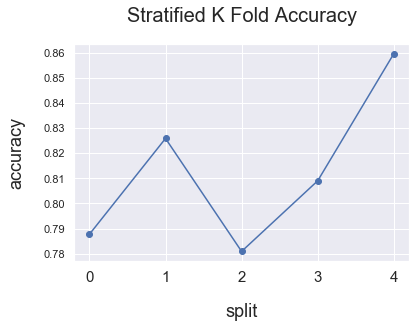

In [113]:
def create_model_0():
    model = keras.Sequential(name="titanic_m0")
    model.add(keras.layers.Input(shape=X_train.shape[1], name='input'))
    model.add(keras.layers.Dense(6, activation="tanh", name="layer_1"))
    model.add(keras.layers.Dense(6, activation="tanh", name="layer_2"))
    model.add(keras.layers.Dense(1, activation="sigmoid", name="output"))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

results = run_cv_on_estimator(create_model_0, X, y)
plot_results_accuracy(results)

So the variance seems to be quite high, as the accuracy is quite different for each fold (i.e. the standard deviation of the accuracy across training folds is not close to 0).

What can we do about this? **Apply regularization for starters!**

# model 1 - L2 regularization

Model: "titanic_m0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 6)                 96        
_________________________________________________________________
layer_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
output (Dense)               (None, 1)                 7         
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
23/23 [==============================] - 0s 1ms/step - loss: 0.6231 - accuracy: 0.7022
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6094 - accuracy: 0.7037
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6004 - accuracy: 0.7037
Epoch 4/100
23/23 [==============================] - 0s 1ms/step - loss: 0.5914 - accuracy:

23/23 [==============================] - 0s 1ms/step - loss: 0.4040 - accuracy: 0.8163
Epoch 49/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4093 - accuracy: 0.8191
Epoch 50/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4025 - accuracy: 0.8275
Epoch 51/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4026 - accuracy: 0.8233
Epoch 52/100
23/23 [==============================] - 0s 1ms/step - loss: 0.3991 - accuracy: 0.8289
Epoch 53/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4049 - accuracy: 0.8205
Epoch 54/100
23/23 [==============================] - 0s 1ms/step - loss: 0.3973 - accuracy: 0.8191
Epoch 55/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4093 - accuracy: 0.8205
Epoch 56/100
23/23 [==============================] - 0s 1ms/step - loss: 0.3996 - accuracy: 0.8317
Epoch 57/100
23/23 [==============================] - 0s 1ms/step - loss: 0.3952 - accuracy: 0.8317
Epoch 58/100


23/23 [==============================] - 0s 1ms/step - loss: 0.5230 - accuracy: 0.7447
Epoch 23/100
23/23 [==============================] - 0s 938us/step - loss: 0.5161 - accuracy: 0.7504
Epoch 24/100
23/23 [==============================] - 0s 1ms/step - loss: 0.5069 - accuracy: 0.7560
Epoch 25/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4902 - accuracy: 0.7518
Epoch 26/100
23/23 [==============================] - 0s 884us/step - loss: 0.4816 - accuracy: 0.7546
Epoch 27/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4673 - accuracy: 0.7826
Epoch 28/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4605 - accuracy: 0.7994
Epoch 29/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4517 - accuracy: 0.8205
Epoch 30/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4503 - accuracy: 0.8177
Epoch 31/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4451 - accuracy: 0.8289
Epoch 32/

Epoch 1/100
23/23 [==============================] - 0s 1ms/step - loss: 0.8128 - accuracy: 0.3773
Epoch 2/100
23/23 [==============================] - 0s 1ms/step - loss: 0.7115 - accuracy: 0.5091
Epoch 3/100
23/23 [==============================] - 0s 1ms/step - loss: 0.6628 - accuracy: 0.6003
Epoch 4/100
23/23 [==============================] - 0s 1ms/step - loss: 0.6424 - accuracy: 0.6227
Epoch 5/100
23/23 [==============================] - 0s 1ms/step - loss: 0.6363 - accuracy: 0.6241
Epoch 6/100
23/23 [==============================] - 0s 1ms/step - loss: 0.6306 - accuracy: 0.6339
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6396
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6247 - accuracy: 0.6452
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6230 - accuracy: 0.6788
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6206 - accuracy: 0.6746
Epoch 11/

23/23 [==============================] - 0s 1ms/step - loss: 0.4324 - accuracy: 0.8289
Epoch 57/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4334 - accuracy: 0.8219
Epoch 58/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4331 - accuracy: 0.8233
Epoch 59/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4315 - accuracy: 0.8275
Epoch 60/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4322 - accuracy: 0.8289
Epoch 61/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4308 - accuracy: 0.8233
Epoch 62/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4325 - accuracy: 0.8317
Epoch 63/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4322 - accuracy: 0.8261
Epoch 64/100
23/23 [==============================] - 0s 951us/step - loss: 0.4346 - accuracy: 0.8247
Epoch 65/100
23/23 [==============================] - 0s 1ms/step - loss: 0.4287 - accuracy: 0.8317
Epoch 66/10

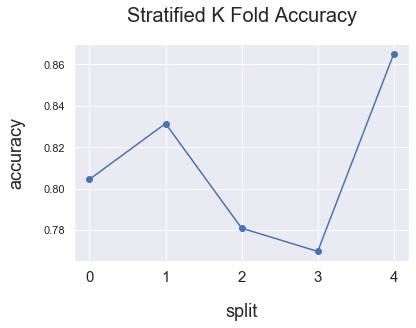

In [122]:
def create_model_1():
    model = keras.Sequential(name="titanic_m0")
    
    model.add(keras.layers.Input(shape=X_train.shape[1], name='input'))
    
    model.add(keras.layers.Dense(6, activation="tanh", name="layer_1", kernel_regularizer=l2(1)))
    
    model.add(keras.layers.Dense(6, activation="tanh", name="layer_2", kernel_regularizer=l2(1)))
    
    model.add(keras.layers.Dense(1, activation="sigmoid", name="output"))
    
    model.summary()
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

results = run_cv_on_estimator(create_model_1, X, y)
plot_results_accuracy(results)

# model 2 - more complex model + L2 & dropout regularization 

This model was also borrowed form https://www.kaggle.com/sreevishnudamodaran/ultimate-eda-fe-neural-network-model-top-2

In [133]:
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout, BatchNormalization,Concatenate, concatenate
from tensorflow.keras.optimizers import SGD, RMSprop, Adamax, Adagrad, Adam, Nadam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential

In [140]:
def create_model_2():
    model = Sequential()
    model.add(Input(shape=X_train.shape[1], name='Input_'))
    model.add(Dense(8, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.001)))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

    model.summary()
    optimize = Adam(lr = 0.0001)
    model.compile(optimizer = optimize, 
                       loss = 'binary_crossentropy', 
                       metrics = ['accuracy'])
    
    return model

In [147]:
EPOCHS = 750
BATCH_SIZE = 32

Model: "titanic_m0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 6)                 96        
_________________________________________________________________
layer_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
output (Dense)               (None, 1)                 7         
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/750
23/23 [==============================] - 0s 1ms/step - loss: 0.7464 - accuracy: 0.4143
Epoch 2/750
23/23 [==============================] - 0s 2ms/step - loss: 0.6622 - accuracy: 0.6419
Epoch 3/750
23/23 [==============================] - 0s 3ms/step - loss: 0.6240 - accuracy: 0.6812
Epoch 4/750
23/23 [==============================] - 0s 2ms/step - loss: 0.6041 - accuracy:

23/23 [==============================] - 0s 1ms/step - loss: 0.3830 - accuracy: 0.8455
Epoch 157/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3816 - accuracy: 0.8413
Epoch 158/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3812 - accuracy: 0.8455
Epoch 159/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3805 - accuracy: 0.8413
Epoch 160/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3831 - accuracy: 0.8371
Epoch 161/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3796 - accuracy: 0.8427
Epoch 162/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3801 - accuracy: 0.8399
Epoch 163/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3804 - accuracy: 0.8441
Epoch 164/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3811 - accuracy: 0.8455
Epoch 165/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3794 - accuracy: 0.8427
Epoc

23/23 [==============================] - 0s 1ms/step - loss: 0.3768 - accuracy: 0.8413
Epoch 238/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3751 - accuracy: 0.8441
Epoch 239/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3756 - accuracy: 0.8399
Epoch 240/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3821 - accuracy: 0.8427
Epoch 241/750
23/23 [==============================] - 0s 972us/step - loss: 0.3844 - accuracy: 0.8427
Epoch 242/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3748 - accuracy: 0.8441
Epoch 243/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3748 - accuracy: 0.8455
Epoch 244/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3756 - accuracy: 0.8455
Epoch 245/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3766 - accuracy: 0.8413
Epoch 246/750
23/23 [==============================] - 0s 955us/step - loss: 0.3771 - accuracy: 0.8469


23/23 [==============================] - 0s 3ms/step - loss: 0.3803 - accuracy: 0.8497
Epoch 319/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3791 - accuracy: 0.8455
Epoch 320/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3732 - accuracy: 0.8511
Epoch 321/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3716 - accuracy: 0.8469
Epoch 322/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3730 - accuracy: 0.8525
Epoch 323/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3733 - accuracy: 0.8427
Epoch 324/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3720 - accuracy: 0.8455
Epoch 325/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3715 - accuracy: 0.8441
Epoch 326/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3742 - accuracy: 0.8497
Epoch 327/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3719 - accuracy: 0.8483
Epoc

23/23 [==============================] - 0s 881us/step - loss: 0.3673 - accuracy: 0.8497
Epoch 479/750
23/23 [==============================] - 0s 957us/step - loss: 0.3701 - accuracy: 0.8427
Epoch 480/750
23/23 [==============================] - 0s 898us/step - loss: 0.3690 - accuracy: 0.8469
Epoch 481/750
23/23 [==============================] - 0s 899us/step - loss: 0.3659 - accuracy: 0.8497
Epoch 482/750
23/23 [==============================] - 0s 913us/step - loss: 0.3685 - accuracy: 0.8455
Epoch 483/750
23/23 [==============================] - 0s 962us/step - loss: 0.3689 - accuracy: 0.8441
Epoch 484/750
23/23 [==============================] - 0s 913us/step - loss: 0.3674 - accuracy: 0.8497
Epoch 485/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3691 - accuracy: 0.8497
Epoch 486/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3687 - accuracy: 0.8511
Epoch 487/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3683 - accurac

23/23 [==============================] - 0s 995us/step - loss: 0.3624 - accuracy: 0.8469
Epoch 639/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3637 - accuracy: 0.8483
Epoch 640/750
23/23 [==============================] - 0s 968us/step - loss: 0.3666 - accuracy: 0.8497
Epoch 641/750
23/23 [==============================] - 0s 1000us/step - loss: 0.3639 - accuracy: 0.8469
Epoch 642/750
23/23 [==============================] - 0s 990us/step - loss: 0.3670 - accuracy: 0.8525
Epoch 643/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3638 - accuracy: 0.8511
Epoch 644/750
23/23 [==============================] - 0s 933us/step - loss: 0.3619 - accuracy: 0.8553
Epoch 645/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3610 - accuracy: 0.8553
Epoch 646/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3608 - accuracy: 0.8553
Epoch 647/750
23/23 [==============================] - 0s 976us/step - loss: 0.3626 - accuracy

23/23 [==============================] - 0s 1ms/step - loss: 0.4309 - accuracy: 0.8275
Epoch 40/750
23/23 [==============================] - 0s 986us/step - loss: 0.4249 - accuracy: 0.8261
Epoch 41/750
23/23 [==============================] - 0s 952us/step - loss: 0.4232 - accuracy: 0.8261
Epoch 42/750
23/23 [==============================] - 0s 1ms/step - loss: 0.4193 - accuracy: 0.8331
Epoch 43/750
23/23 [==============================] - 0s 902us/step - loss: 0.4171 - accuracy: 0.8345
Epoch 44/750
23/23 [==============================] - 0s 883us/step - loss: 0.4165 - accuracy: 0.8303
Epoch 45/750
23/23 [==============================] - 0s 933us/step - loss: 0.4154 - accuracy: 0.8345
Epoch 46/750
23/23 [==============================] - 0s 885us/step - loss: 0.4121 - accuracy: 0.8359
Epoch 47/750
23/23 [==============================] - 0s 1ms/step - loss: 0.4095 - accuracy: 0.8373
Epoch 48/750
23/23 [==============================] - 0s 869us/step - loss: 0.4101 - accuracy: 0.8317

23/23 [==============================] - 0s 1ms/step - loss: 0.3500 - accuracy: 0.8513
Epoch 200/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3504 - accuracy: 0.8471
Epoch 201/750
23/23 [==============================] - 0s 984us/step - loss: 0.3511 - accuracy: 0.8513
Epoch 202/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3544 - accuracy: 0.8457
Epoch 203/750
23/23 [==============================] - 0s 993us/step - loss: 0.3591 - accuracy: 0.8485
Epoch 204/750
23/23 [==============================] - 0s 996us/step - loss: 0.3534 - accuracy: 0.8513
Epoch 205/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3494 - accuracy: 0.8541
Epoch 206/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3510 - accuracy: 0.8527
Epoch 207/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3517 - accuracy: 0.8513
Epoch 208/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3506 - accuracy: 0.845

23/23 [==============================] - 0s 873us/step - loss: 0.3337 - accuracy: 0.8541
Epoch 360/750
23/23 [==============================] - 0s 925us/step - loss: 0.3341 - accuracy: 0.8583
Epoch 361/750
23/23 [==============================] - 0s 915us/step - loss: 0.3334 - accuracy: 0.8527
Epoch 362/750
23/23 [==============================] - 0s 865us/step - loss: 0.3338 - accuracy: 0.8527
Epoch 363/750
23/23 [==============================] - 0s 881us/step - loss: 0.3338 - accuracy: 0.8569
Epoch 364/750
23/23 [==============================] - 0s 852us/step - loss: 0.3331 - accuracy: 0.8527
Epoch 365/750
23/23 [==============================] - 0s 866us/step - loss: 0.3330 - accuracy: 0.8541
Epoch 366/750
23/23 [==============================] - 0s 877us/step - loss: 0.3379 - accuracy: 0.8499
Epoch 367/750
23/23 [==============================] - 0s 871us/step - loss: 0.3347 - accuracy: 0.8527
Epoch 368/750
23/23 [==============================] - 0s 846us/step - loss: 0.3339 - a

23/23 [==============================] - 0s 1ms/step - loss: 0.3273 - accuracy: 0.8555
Epoch 521/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3289 - accuracy: 0.8555
Epoch 522/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3264 - accuracy: 0.8541
Epoch 523/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3250 - accuracy: 0.8569
Epoch 524/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3252 - accuracy: 0.8541
Epoch 525/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3266 - accuracy: 0.8555
Epoch 526/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3254 - accuracy: 0.8555
Epoch 527/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3261 - accuracy: 0.8541
Epoch 528/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3259 - accuracy: 0.8541
Epoch 529/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3284 - accuracy: 0.8541
Epoc

23/23 [==============================] - 0s 1ms/step - loss: 0.3192 - accuracy: 0.8555
Epoch 682/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3181 - accuracy: 0.8569
Epoch 683/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3215 - accuracy: 0.8583
Epoch 684/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3215 - accuracy: 0.8541
Epoch 685/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3208 - accuracy: 0.8583
Epoch 686/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3188 - accuracy: 0.8555
Epoch 687/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3205 - accuracy: 0.8555
Epoch 688/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3187 - accuracy: 0.8569
Epoch 689/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3185 - accuracy: 0.8555
Epoch 690/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3203 - accuracy: 0.8597
Epoc

23/23 [==============================] - 0s 1ms/step - loss: 0.4232 - accuracy: 0.8275
Epoch 87/750
23/23 [==============================] - 0s 2ms/step - loss: 0.4203 - accuracy: 0.8275
Epoch 88/750
23/23 [==============================] - 0s 2ms/step - loss: 0.4211 - accuracy: 0.8261
Epoch 89/750
23/23 [==============================] - 0s 1ms/step - loss: 0.4202 - accuracy: 0.8275
Epoch 90/750
23/23 [==============================] - 0s 1ms/step - loss: 0.4201 - accuracy: 0.8289
Epoch 91/750
23/23 [==============================] - 0s 1ms/step - loss: 0.4198 - accuracy: 0.8261
Epoch 92/750
23/23 [==============================] - 0s 1ms/step - loss: 0.4189 - accuracy: 0.8289
Epoch 93/750
23/23 [==============================] - 0s 1ms/step - loss: 0.4206 - accuracy: 0.8317
Epoch 94/750
23/23 [==============================] - 0s 1ms/step - loss: 0.4172 - accuracy: 0.8247
Epoch 95/750
23/23 [==============================] - 0s 1ms/step - loss: 0.4158 - accuracy: 0.8303
Epoch 96/750


23/23 [==============================] - 0s 1ms/step - loss: 0.3808 - accuracy: 0.8401
Epoch 248/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3780 - accuracy: 0.8429
Epoch 249/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3859 - accuracy: 0.8401
Epoch 250/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3797 - accuracy: 0.8401
Epoch 251/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3807 - accuracy: 0.8331
Epoch 252/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3910 - accuracy: 0.8317
Epoch 253/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3774 - accuracy: 0.8429
Epoch 254/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3767 - accuracy: 0.8415
Epoch 255/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3760 - accuracy: 0.8457
Epoch 256/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3777 - accuracy: 0.8457
Epoc

Epoch 409/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3649 - accuracy: 0.8457
Epoch 410/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3662 - accuracy: 0.8415
Epoch 411/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3641 - accuracy: 0.8443
Epoch 412/750
23/23 [==============================] - 0s 981us/step - loss: 0.3648 - accuracy: 0.8457
Epoch 413/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3637 - accuracy: 0.8415
Epoch 414/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3633 - accuracy: 0.8429
Epoch 415/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3633 - accuracy: 0.8443
Epoch 416/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3641 - accuracy: 0.8443
Epoch 417/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3631 - accuracy: 0.8429
Epoch 418/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3621 - accur

23/23 [==============================] - 0s 2ms/step - loss: 0.3623 - accuracy: 0.8387
Epoch 491/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3652 - accuracy: 0.8359
Epoch 492/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3601 - accuracy: 0.8443
Epoch 493/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3611 - accuracy: 0.8401
Epoch 494/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3598 - accuracy: 0.8387
Epoch 495/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3573 - accuracy: 0.8457
Epoch 496/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3699 - accuracy: 0.8359
Epoch 497/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3625 - accuracy: 0.8415
Epoch 498/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3592 - accuracy: 0.8443
Epoch 499/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3605 - accuracy: 0.8471
Epoc

23/23 [==============================] - 0s 1ms/step - loss: 0.3496 - accuracy: 0.8485
Epoch 653/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3489 - accuracy: 0.8443
Epoch 654/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3482 - accuracy: 0.8443
Epoch 655/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3495 - accuracy: 0.8457
Epoch 656/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3495 - accuracy: 0.8485
Epoch 657/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3672 - accuracy: 0.8359
Epoch 658/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3558 - accuracy: 0.8429
Epoch 659/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3504 - accuracy: 0.8443
Epoch 660/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3527 - accuracy: 0.8429
Epoch 661/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3511 - accuracy: 0.8415
Epoc

23/23 [==============================] - 0s 1ms/step - loss: 0.3458 - accuracy: 0.8443
Epoch 734/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3473 - accuracy: 0.8443
Epoch 735/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3477 - accuracy: 0.8471
Epoch 736/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3479 - accuracy: 0.8485
Epoch 737/750
23/23 [==============================] - 0s 950us/step - loss: 0.3454 - accuracy: 0.8499
Epoch 738/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3449 - accuracy: 0.8457
Epoch 739/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3492 - accuracy: 0.8471
Epoch 740/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3463 - accuracy: 0.8457
Epoch 741/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3478 - accuracy: 0.8457
Epoch 742/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3453 - accuracy: 0.8485
Ep

23/23 [==============================] - 0s 1ms/step - loss: 0.3765 - accuracy: 0.8471
Epoch 138/750
23/23 [==============================] - 0s 913us/step - loss: 0.3751 - accuracy: 0.8499
Epoch 139/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3812 - accuracy: 0.8429
Epoch 140/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3777 - accuracy: 0.8471
Epoch 141/750
23/23 [==============================] - 0s 998us/step - loss: 0.3763 - accuracy: 0.8485
Epoch 142/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3788 - accuracy: 0.8457
Epoch 143/750
23/23 [==============================] - 0s 991us/step - loss: 0.3764 - accuracy: 0.8443
Epoch 144/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3749 - accuracy: 0.8457
Epoch 145/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3750 - accuracy: 0.8457
Epoch 146/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3741 - accuracy: 0.848

23/23 [==============================] - 0s 1ms/step - loss: 0.3608 - accuracy: 0.8499
Epoch 299/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3579 - accuracy: 0.8527
Epoch 300/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3588 - accuracy: 0.8527
Epoch 301/750
23/23 [==============================] - 0s 3ms/step - loss: 0.3603 - accuracy: 0.8555
Epoch 302/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3584 - accuracy: 0.8569
Epoch 303/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3589 - accuracy: 0.8569
Epoch 304/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3580 - accuracy: 0.8513
Epoch 305/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3586 - accuracy: 0.8499
Epoch 306/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3588 - accuracy: 0.8541
Epoch 307/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3578 - accuracy: 0.8555
Epoc

23/23 [==============================] - 0s 1ms/step - loss: 0.3549 - accuracy: 0.8555
Epoch 380/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3580 - accuracy: 0.8499
Epoch 381/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3538 - accuracy: 0.8513
Epoch 382/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3545 - accuracy: 0.8569
Epoch 383/750
23/23 [==============================] - 0s 930us/step - loss: 0.3555 - accuracy: 0.8541
Epoch 384/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3538 - accuracy: 0.8499
Epoch 385/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3572 - accuracy: 0.8499
Epoch 386/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3564 - accuracy: 0.8555
Epoch 387/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3538 - accuracy: 0.8499
Epoch 388/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3527 - accuracy: 0.8555
Ep

Epoch 460/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3503 - accuracy: 0.8485
Epoch 461/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3501 - accuracy: 0.8569
Epoch 462/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3488 - accuracy: 0.8527
Epoch 463/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3509 - accuracy: 0.8527
Epoch 464/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3490 - accuracy: 0.8583
Epoch 465/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3496 - accuracy: 0.8541
Epoch 466/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3494 - accuracy: 0.8541
Epoch 467/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3504 - accuracy: 0.8513
Epoch 468/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3492 - accuracy: 0.8541
Epoch 469/750
23/23 [==============================] - 0s 2ms/step - loss: 0.3496 - accurac

23/23 [==============================] - 0s 809us/step - loss: 0.3445 - accuracy: 0.8569
Epoch 622/750
23/23 [==============================] - 0s 878us/step - loss: 0.3428 - accuracy: 0.8583
Epoch 623/750
23/23 [==============================] - 0s 929us/step - loss: 0.3432 - accuracy: 0.8597
Epoch 624/750
23/23 [==============================] - 0s 818us/step - loss: 0.3428 - accuracy: 0.8583
Epoch 625/750
23/23 [==============================] - 0s 839us/step - loss: 0.3432 - accuracy: 0.8485
Epoch 626/750
23/23 [==============================] - 0s 812us/step - loss: 0.3451 - accuracy: 0.8583
Epoch 627/750
23/23 [==============================] - 0s 796us/step - loss: 0.3440 - accuracy: 0.8555
Epoch 628/750
23/23 [==============================] - 0s 924us/step - loss: 0.3446 - accuracy: 0.8583
Epoch 629/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3434 - accuracy: 0.8555
Epoch 630/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3431 - accur

23/23 [==============================] - 0s 1ms/step - loss: 0.5762 - accuracy: 0.7055
Epoch 25/750
23/23 [==============================] - 0s 1ms/step - loss: 0.5712 - accuracy: 0.7055
Epoch 26/750
23/23 [==============================] - 0s 1ms/step - loss: 0.5641 - accuracy: 0.7153
Epoch 27/750
23/23 [==============================] - 0s 1ms/step - loss: 0.5581 - accuracy: 0.7195
Epoch 28/750
23/23 [==============================] - 0s 1ms/step - loss: 0.5529 - accuracy: 0.7125
Epoch 29/750
23/23 [==============================] - 0s 1ms/step - loss: 0.5487 - accuracy: 0.7167
Epoch 30/750
23/23 [==============================] - 0s 960us/step - loss: 0.5447 - accuracy: 0.7209
Epoch 31/750
23/23 [==============================] - 0s 1ms/step - loss: 0.5413 - accuracy: 0.7307
Epoch 32/750
23/23 [==============================] - 0s 1ms/step - loss: 0.5376 - accuracy: 0.7433
Epoch 33/750
23/23 [==============================] - 0s 928us/step - loss: 0.5348 - accuracy: 0.7433
Epoch 34/

23/23 [==============================] - 0s 1ms/step - loss: 0.3908 - accuracy: 0.8303
Epoch 187/750
23/23 [==============================] - 0s 924us/step - loss: 0.3906 - accuracy: 0.8359
Epoch 188/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3903 - accuracy: 0.8373
Epoch 189/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3898 - accuracy: 0.8317
Epoch 190/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3887 - accuracy: 0.8317
Epoch 191/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3906 - accuracy: 0.8373
Epoch 192/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3906 - accuracy: 0.8359
Epoch 193/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3918 - accuracy: 0.8359
Epoch 194/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3881 - accuracy: 0.8415
Epoch 195/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3887 - accuracy: 0.8359
Ep

23/23 [==============================] - 0s 1ms/step - loss: 0.3826 - accuracy: 0.8373
Epoch 268/750
23/23 [==============================] - 0s 987us/step - loss: 0.3796 - accuracy: 0.8457
Epoch 269/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3796 - accuracy: 0.8387
Epoch 270/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3804 - accuracy: 0.8387
Epoch 271/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3804 - accuracy: 0.8401
Epoch 272/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3790 - accuracy: 0.8443
Epoch 273/750
23/23 [==============================] - 0s 938us/step - loss: 0.3803 - accuracy: 0.8331
Epoch 274/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3790 - accuracy: 0.8373
Epoch 275/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3793 - accuracy: 0.8387
Epoch 276/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3804 - accuracy: 0.8359


Epoch 428/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3732 - accuracy: 0.8471
Epoch 429/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3723 - accuracy: 0.8485
Epoch 430/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3708 - accuracy: 0.8499
Epoch 431/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3735 - accuracy: 0.8513
Epoch 432/750
23/23 [==============================] - 0s 933us/step - loss: 0.3709 - accuracy: 0.8485
Epoch 433/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3711 - accuracy: 0.8471
Epoch 434/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3732 - accuracy: 0.8457
Epoch 435/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3725 - accuracy: 0.8499
Epoch 436/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3715 - accuracy: 0.8471
Epoch 437/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3713 - accur

23/23 [==============================] - 0s 1ms/step - loss: 0.3660 - accuracy: 0.8513
Epoch 590/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3657 - accuracy: 0.8471
Epoch 591/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3651 - accuracy: 0.8527
Epoch 592/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3658 - accuracy: 0.8527
Epoch 593/750
23/23 [==============================] - 0s 939us/step - loss: 0.3644 - accuracy: 0.8527
Epoch 594/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3653 - accuracy: 0.8513
Epoch 595/750
23/23 [==============================] - 0s 987us/step - loss: 0.3643 - accuracy: 0.8513
Epoch 596/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3657 - accuracy: 0.8555
Epoch 597/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3650 - accuracy: 0.8513
Epoch 598/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3658 - accuracy: 0.8583


23/23 [==============================] - 0s 1ms/step - loss: 0.3637 - accuracy: 0.8569
Epoch 671/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3663 - accuracy: 0.8555
Epoch 672/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3709 - accuracy: 0.8555
Epoch 673/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3637 - accuracy: 0.8569
Epoch 674/750
23/23 [==============================] - 0s 988us/step - loss: 0.3639 - accuracy: 0.8527
Epoch 675/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3640 - accuracy: 0.8555
Epoch 676/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3672 - accuracy: 0.8555
Epoch 677/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3712 - accuracy: 0.8471
Epoch 678/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3626 - accuracy: 0.8541
Epoch 679/750
23/23 [==============================] - 0s 1ms/step - loss: 0.3627 - accuracy: 0.8555
Ep

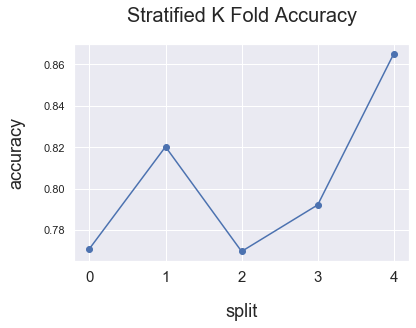

In [148]:
results = run_cv_on_estimator(create_model_2, X, y, epochs=EPOCHS, batch_size=BATCH_SIZE)
plot_results_accuracy(results)

In [145]:
# we're going to use sklearn's cross validation functions, so we'll wrap our keras model in an sklearn model wrapper
estimator = KerasClassifier(build_fn = create_model_2, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = 1)
train_history = estimator.fit(X, y, epochs = EPOCHS, batch_size = BATCH_SIZE)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 8)                 128       
_________________________________________________________________
dense_37 (Dense)             (None, 16)                144       
_________________________________________________________________
dropout_18 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_19 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 17        
Total params: 561
Trainable params: 561
Non-trainable params: 0
_______________________________________________________

28/28 [==============================] - 0s 1ms/step - loss: 1.0416 - accuracy: 0.6543
Epoch 152/750
28/28 [==============================] - 0s 908us/step - loss: 1.0212 - accuracy: 0.6622
Epoch 153/750
28/28 [==============================] - 0s 979us/step - loss: 1.0480 - accuracy: 0.6397
Epoch 154/750
28/28 [==============================] - 0s 925us/step - loss: 1.0318 - accuracy: 0.6498
Epoch 155/750
28/28 [==============================] - 0s 906us/step - loss: 1.0242 - accuracy: 0.6543
Epoch 156/750
28/28 [==============================] - 0s 975us/step - loss: 1.0093 - accuracy: 0.6476
Epoch 157/750
28/28 [==============================] - 0s 935us/step - loss: 1.0146 - accuracy: 0.6431
Epoch 158/750
28/28 [==============================] - 0s 922us/step - loss: 0.9935 - accuracy: 0.6543
Epoch 159/750
28/28 [==============================] - 0s 904us/step - loss: 0.9975 - accuracy: 0.6588
Epoch 160/750
28/28 [==============================] - 0s 918us/step - loss: 0.9963 - acc

28/28 [==============================] - 0s 1ms/step - loss: 0.6550 - accuracy: 0.6599
Epoch 312/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6446 - accuracy: 0.6577
Epoch 313/750
28/28 [==============================] - 0s 997us/step - loss: 0.6573 - accuracy: 0.6554
Epoch 314/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6592 - accuracy: 0.6644
Epoch 315/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6525 - accuracy: 0.6644
Epoch 316/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6598 - accuracy: 0.6655
Epoch 317/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6431 - accuracy: 0.6712
Epoch 318/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6464 - accuracy: 0.6566
Epoch 319/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6469 - accuracy: 0.6667
Epoch 320/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6551 - accuracy: 0.6633
Ep

28/28 [==============================] - 0s 1ms/step - loss: 0.6066 - accuracy: 0.6981
Epoch 472/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6094 - accuracy: 0.6981
Epoch 473/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6155 - accuracy: 0.6857
Epoch 474/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6051 - accuracy: 0.6891
Epoch 475/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6038 - accuracy: 0.6925
Epoch 476/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6084 - accuracy: 0.6902
Epoch 477/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6004 - accuracy: 0.7003
Epoch 478/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6087 - accuracy: 0.6768
Epoch 479/750
28/28 [==============================] - 0s 2ms/step - loss: 0.6079 - accuracy: 0.6880
Epoch 480/750
28/28 [==============================] - 0s 1ms/step - loss: 0.6015 - accuracy: 0.6970
Epoc

28/28 [==============================] - 0s 1ms/step - loss: 0.5762 - accuracy: 0.7598
Epoch 634/750
28/28 [==============================] - 0s 1ms/step - loss: 0.5782 - accuracy: 0.7363
Epoch 635/750
28/28 [==============================] - 0s 1ms/step - loss: 0.5718 - accuracy: 0.7407
Epoch 636/750
28/28 [==============================] - 0s 1ms/step - loss: 0.5615 - accuracy: 0.7677
Epoch 637/750
28/28 [==============================] - 0s 1ms/step - loss: 0.5712 - accuracy: 0.7486
Epoch 638/750
28/28 [==============================] - 0s 1ms/step - loss: 0.5714 - accuracy: 0.7621
Epoch 639/750
28/28 [==============================] - 0s 1ms/step - loss: 0.5528 - accuracy: 0.7621
Epoch 640/750
28/28 [==============================] - 0s 1ms/step - loss: 0.5707 - accuracy: 0.7542
Epoch 641/750
28/28 [==============================] - 0s 1ms/step - loss: 0.5740 - accuracy: 0.7565
Epoch 642/750
28/28 [==============================] - 0s 1ms/step - loss: 0.5673 - accuracy: 0.7542
Epoc

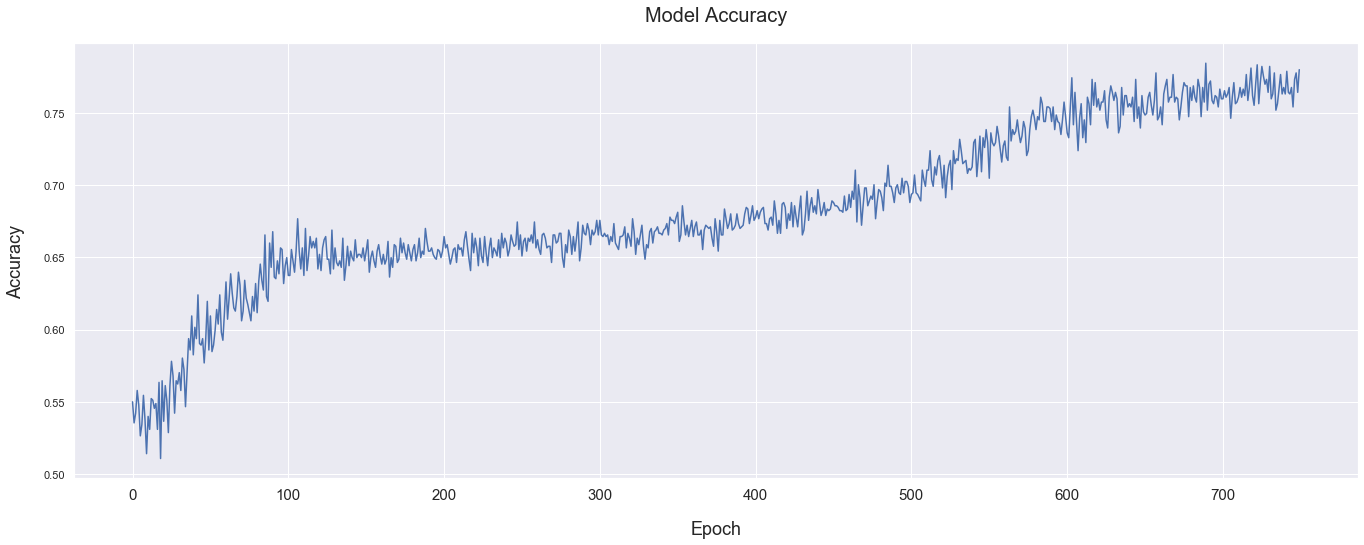

In [149]:
plt.figure(figsize=(23,8))
sns.lineplot(data=train_history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Conclusion

Interestingly, the logistic regression classifier had the highest accuracy across K-fold cross validation (83%).
The the highly regularized (including L2 and dropout regularization) neural network had roughly the same performance metrics in terms of mean accuracy and accuracy standard deviation as the other neural network models trained.

Options to improve bias in the NN:
- Feature engineering
- Train a more complex NN architecture
    - Train a bigger model, add more layers, add more nodes
- Hyper-parameter tuning
- Train longer

# Prediction File Generation

In [152]:
# neural network
y_pred_test_proba = estimator.predict(X_test)
y_pred_test = (y_pred_test_proba > 0.5).astype(int).flatten()

submission = pd.DataFrame(
    { 
        'PassengerId': df_test['PassengerId'], 
        'Survived': y_pred
    }
)
submission.to_csv("submission.csv", index=False)

14/14 [==============================] - 0s 671us/step
